# HW12 - Watershed - Xenia De Gracia

## Model Description 
This is a steady state, layered box model with recharge, ET, pumping wells and a river.

#### Dimensions: 
- 50 by 50 by 3
- dx = dy = 1000 m
- dz = 1000 m  

#### Topography
- Land surface is given by a CSV file read by the model.
- sloping linearly to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Heterogeneous 
- K = 8.5 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient = 0.0001  

#### Boundary Conditions: 
 - Left boundary is a no flow condition
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 4e-5 m/d in the 20 left columns and it is zero in the rest of the domain
 
#### Wells: 
 - Town well
     - Located at (2, 21, 38) (layer, row, column)
     - Pumping at a rate of -1500 m^3/day
 - Agricultural well
     - Located at (0, 12, 14) (layer, row, column)
     - Pumping at a rate of -3000 m^3/day

#### Layered Scenario
 - Number of layers: 3
 - Low K layer - Kx=Ky=K_horizontal. Kz=0.0001m/d
 - Extends from 40-45m above the base of the domain
     

## 1. Setup the environment

In [1045]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os
import math
import pandas as pd

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline


## 2. Setup the input variables 

In [1046]:
## model directory
moddir="../../mf2005"

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1  #number of layers #it will change in future

dx= 100 #width of grid cells in x direction 
dy= 100 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: #reading the topography
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
#print(ztop.shape)
# print(ztop[0,:])
zbot = 0.     #bottom elevation
dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#Xenia: we will have now 4 dimensions(time, layers, xaxis, yaxis)

## Subsurface properties
K_horiz = 8.5    #assign horizontal hydraulic conductivity (along x and y axis)
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 1e-4      #assign storage coefficient
#Ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
#Ss[:,:,:] = 1e-4 #NOTE verify if this has to be in 2D or 3D
Sy = 0.10        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Recharge
recharge = 4e-5 #m/day
pistachios_demand = 6e-3
pistachios_rch = pistachios_demand * (20/100)

#Town Well
pumping_town = -1500 #m3/day  #given
well_lay_town = 2 #Well located in the bottom layer
well_row_town = 21
well_loc_town = (well_lay_town,21,38) #Well loc should be layer, row, column
print("The Town well location is: ", well_loc_town)
#Agricultural Well
pumping_agric = (1/8) * -3000 #m3/day  #given
well_lay_agric = 0 #Well located in the bottom layer
well_row_agric = 12
well_loc_agric = (well_lay_agric,12,14) #Well loc should be layer, row, column
print("The Agricultural well location is: ", well_loc_agric)

## Boundary conditions
h_right = 70


The Town well location is:  (2, 21, 38)
The Agricultural well location is:  (0, 12, 14)


## 3. Setup and run MODFLOW for the three layer scenario 

In [1047]:
#Initialize the model
modelname = "NTNA"
m = flopy.modflow.Modflow(modelname, exe_name = moddir) #creating a new object to apply the packages to it

## Make some changes to the parameters
nlay=3  #three layers instead of 1
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[0,:,:] = 45                 # bottom elevation of top layer (1) is 25 m RELATIVE to the bottom of the domain
botm[1,:,:] = 40                  # bottom elevation of middle layer (0) is 35 m RELATIVE to the bottom of the domain

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol). Now our K are 3D
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:] = 0.0001                   # Replace the K in the MIDDLE layer with the lower value

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#ibound[:, 0, :] = 0                                 #replace top border row (all zs, all ys, first x) with 0 to indicate no flow
#ibound[:, -1, :] = 0                                 #replace bottom border row (all zs, all ys, first x) with 0 to indicate no flow
ibound[:,:,0] = 0          #replace leftmost column (all zs, all ys, first x) with 0 to indicate no flow
ibound[:,:,-1] = -1          #replace rightmost column (all zs, all ys, first x) with <0 to indicate constant head
#Wall of rock on the left boundary. For-loop provided by Diana Hsieh.
for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+i] = 0


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:15] = recharge            #adding recharge to the most left 20 columns
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object
rech_zone_df = pd.DataFrame(rech_zone)
rech_zone_df.to_csv()

# #Well - Town
# well_town = [i for i in well_loc_town] + [pumping_town]
# print("Town Well [layer, row, column, flux]: \n", well_town)
# #Well - Agric
# well_agric = [i for i in well_loc_agric] + [pumping_agric]
# print("Agric Well [layer, row, column, flux]: \n", well_agric)
# #Fluxes
# sp_fluxes = {0: [well_agric], 2: [well_town]} #putting the Town well in the bottom layer and the Agric well in the top layer
# wel = flopy.modflow.ModflowWel(model=m, stress_period_data=sp_fluxes)
# print(sp_fluxes)

#ET
ET_zone = np.zeros((1,nrow,ncol)) #NOTE check it I need to add the nlay here or just leave like that    # define an array of zeros the size of the model grid
rightET = 1e-5
riparianET = 5e-4
ET_zone[:,:,25:-1] = rightET
ET_zone[:,22:28,:] = riparianET
extinction_depth = 1 #depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation
evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m)



## 4. STR Package - NTNA

In [1048]:
#1. Setup the stream characteristics 
nseg = 3 # number of segments
ntrib = 2 # two tributaries (for return flow & upstream section)
slope = 0.001  #slope of streambed (m/m)
rough = 0.04 #roughness of streambed
width = 1. #x-sectional width of channel (m)
stage = 0.5 #head of the river
Flow_into_the_1st_reach = 0 # m^3/day
set_icalc = 1  # the stage is to be calculated based on flow
const = 86400.0 #multiplication constant for m3/day 
#2. Calculate the streambed conductance 
k_strbott = 10  #river bottom hydraulic conductivity in l/t
sed_thick = 1 #thickness of riverbed sediment 
cond = k_strbott*(width)*(dy)/(sed_thick) 

#3. Setup the reach locations stream segment numbers and reach numbers
#(Note we are taking a slightly more complicated approach here setting the streambed relative to the elevation of the land surface)
#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 25    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#Setup the inflows for the reaches
Qreturn = 0     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

#4. Setup the elevation of the streams
#(In this case we will be setting it relative to surface elevation which is an array called ‘ztop’)

ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage      # elevation of the water surface in the stream (m)

#5. Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#5. Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

#6. Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


## Run Flopy model with all the packages

In [1049]:
#write the inputs
m.write_input()    

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: NTNA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21  6:27:43

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21  6:27:43
 Elapsed run time:  0.198 Seconds

  Normal termination of simulation


# 5. Plain view of the domain

Text(0.5, 1.0, 'NTNA Domain. Top Layer')

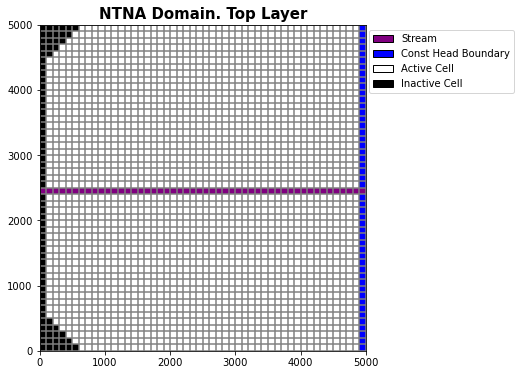

In [1050]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m, layer=0) #everytime we need to plot something, we need to specify the model object.
ibound = mapview.plot_ibound()
#wel = mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()
plt.legend(handles=[#mp.patches.Patch(color='red',label='Well',ec='black'),
                    mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.47,1.0))
str_m = mapview.plot_bc("STR")
plt.title('NTNA Domain. Top Layer', fontsize = 15, fontweight = 'bold')

# 6. Read in the outputs

### 6.1 Modflow outputs - Heads and budget files
#### (Reading different model objects in the same script)

In [1051]:
#Head - 3 layer model 
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                 #returns a list of timesteps
head = headobj.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance - 3 layer
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
print(budgobj.get_unique_record_names())
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps                         #ISNT THIS SUPOSE TO BE BUDOBJ3??
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge = budgobj.get_data(text='RECHARGE', totim=1.0) 
print(len(frf))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
1


# 7. Plotting
### 7.1 Cross section plots

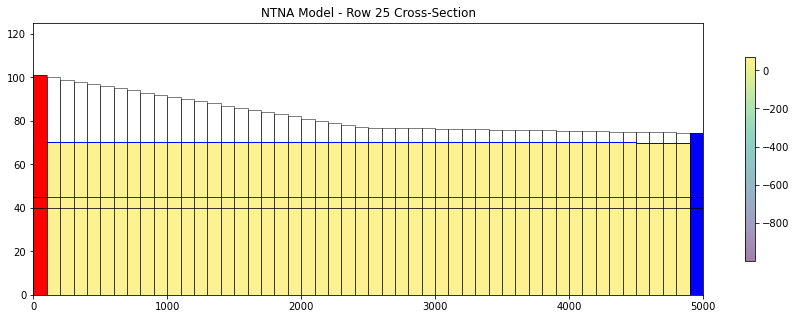

In [1052]:
#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('NTNA Model - Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)


### Read the Water balance and get the heads, ET and Recharge

In [1053]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')  # reads the cell budget file
kstpkper_list = budgobj.get_kstpkper() #returns a list of stress periods & timesteps
#dummy = budgobj.list_records()

#Get the ET from the cell budget files
et = budgobj.get_data(text='et', totim=1.0)
et_vals = np.squeeze(et)[0,:,:] #This is a matrix of the ET fluxes [m3/day] #NOTE I changed here from 1 to zero. Is it the layer number?
et_tot= np.sum(et_vals)
print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
recharge = budgobj.get_data(text='recharge', totim=1.0)
recharge_vals = np.squeeze(recharge)[1,:,:] #This is a matrix of the recharge fluxes [m3/day]
rch_tot = np.sum(recharge_vals)
print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain

# Get the flow rates on the cell right and front faces
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)
flux_vals = np.squeeze(frf)
leftflux = np.round(flux_vals[:, 0], 4)
rightflux = np.round(flux_vals[:, -2], 4)

# Calculate the total flux across the right and left side of the domain
right_tot = np.sum(rightflux)  # Note the units of this are L3/T
left_tot = np.sum(leftflux)

print('Left Flux =', left_tot, " Right_flux=", right_tot)


Total ET [m3/day]: 2500.0
Total Recharge [m3/day]: 267.9999840259552
Left Flux = 206.11002  Right_flux= 209.397


### 7.2 Plot ET, Recharge and WTD

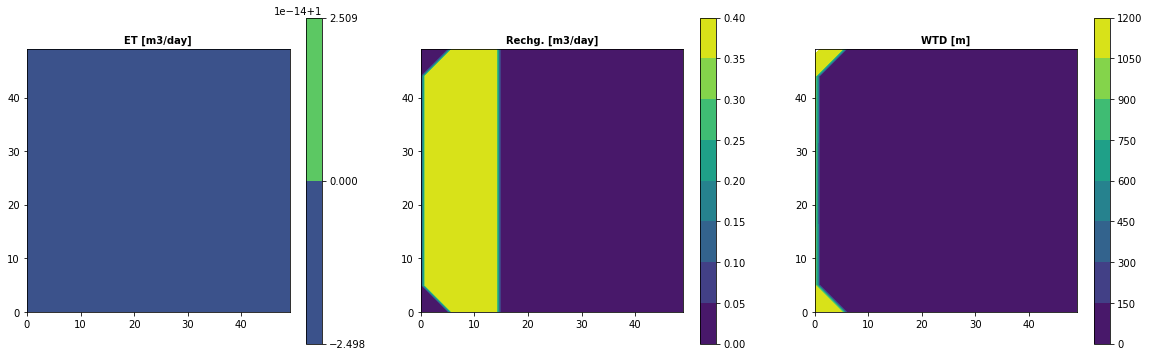

In [1054]:
#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#fig.tight_layout(pad=1)
fig.set_figheight(10)
fig.set_figwidth(20)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
ax1.set_aspect('equal')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.6)

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
ax2.set_aspect('equal')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.6)

#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.6)

plt.show()


### 7.3 Plot head transect

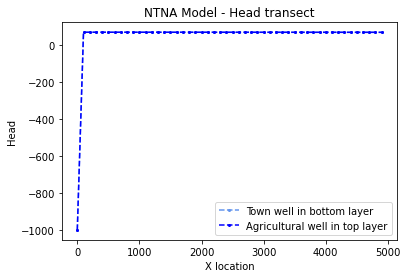

In [1055]:
#Plotting the heads in the rows that contains the wells
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
plt.plot(x,head[2,int(well_row_town),:],marker='.', color='cornflowerblue', markersize=4, linestyle='--', label="Town well in bottom layer")
plt.plot(x,head[0,int(well_row_agric),:],marker='.', color='blue', markersize=4, linestyle='--', label="Agricultural well in top layer")
plt.title('NTNA Model - Head transect')
#plt.title('Head transect for layers with same properties')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()

plt.savefig('NANA Model - Head_Transect.png')
#plt.savefig('Head_Transect for layers with same properties.png')

### 7.4 Layer head contours

C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


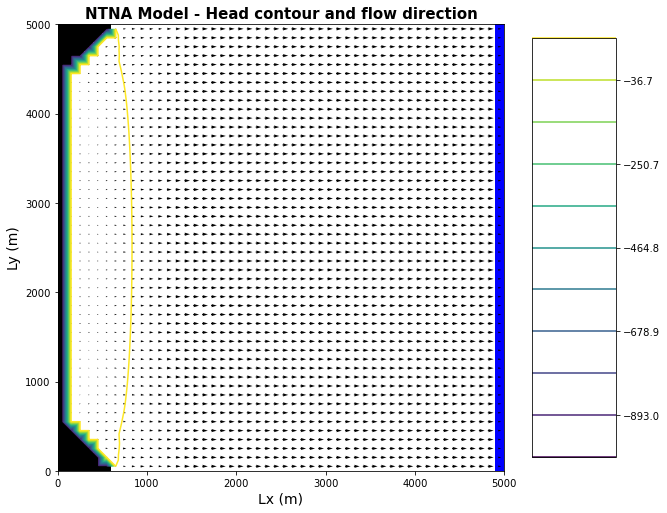

In [1056]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0][0].min(),head[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('NTNA Model - Head contour and flow direction', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

#### 7.5 3D plot of heads

C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_27160\3082112154.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig_3d.gca(projection='3d')


Text(0.5, 0.92, 'NTNA Model - Steady-State Model Head Profile')

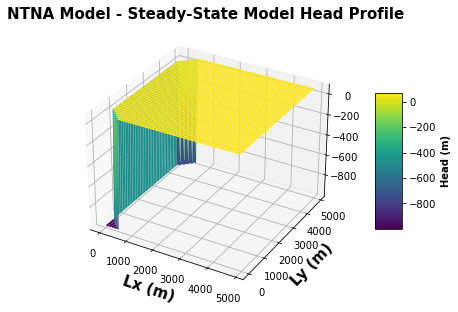

In [1057]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('NTNA Model - Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

## Yes Town No Agric (YTNA)

## 3. Setup and run MODFLOW for the three layer scenario 

In [1058]:
#Initialize the model
modelname = "YTNA"
m2 = flopy.modflow.Modflow(modelname, exe_name = moddir) #creating a new object to apply the packages to it

## Make some changes to the parameters
nlay=3  #three layers instead of 1
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[0,:,:] = 45                 # bottom elevation of top layer (1) is 25 m RELATIVE to the bottom of the domain
botm[1,:,:] = 40                  # bottom elevation of middle layer (0) is 35 m RELATIVE to the bottom of the domain

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol). Now our K are 3D
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:] = 0.0001                   # Replace the K in the MIDDLE layer with the lower value

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m2, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#ibound[:, 0, :] = 0                                 #replace top border row (all zs, all ys, first x) with 0 to indicate no flow
#ibound[:, -1, :] = 0                                 #replace bottom border row (all zs, all ys, first x) with 0 to indicate no flow
ibound[:,:,0] = 0          #replace leftmost column (all zs, all ys, first x) with 0 to indicate no flow
ibound[:,:,-1] = -1          #replace rightmost column (all zs, all ys, first x) with <0 to indicate constant head
#Wall of rock on the left boundary. For-loop provided by Diana Hsieh.
for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+i] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m2, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m2, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
#rech_zone[: , 1:15] = recharge            #adding recharge to the most left 20 columns
rch = flopy.modflow.mfrch.ModflowRch(model=m2, rech=rech_zone, ipakcb=53)     #create rch object
rech_zone_df = pd.DataFrame(rech_zone)
rech_zone_df.to_csv()

#Well - Town
well_town = [i for i in well_loc_town] + [pumping_town]
print("Town Well [layer, row, column, flux]: \n", well_town)
#Fluxes
sp_fluxes = {2: [well_town]} #putting the Town well in the bottom layer and the Agric well in the top layer
wel = flopy.modflow.ModflowWel(model=m2, stress_period_data=sp_fluxes)
print(sp_fluxes)

#ET
ET_zone = np.zeros((1,nrow,ncol)) #NOTE check it I need to add the nlay here or just leave like that    # define an array of zeros the size of the model grid
rightET = 1e-5
riparianET = 5e-4
ET_zone[:,:,26:-1] = rightET
ET_zone[:,22:29,:] = riparianET
extinction_depth = 1 #depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation
evt = flopy.modflow.mfevt.ModflowEvt(model=m2, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m2, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m2)


Town Well [layer, row, column, flux]: 
 [2, 21, 38, -1500]
{2: [[2, 21, 38, -1500]]}


## 4. STR Package - Model YTNA

In [1059]:
#1. Setup the stream characteristics 
nseg = 3 # number of segments
ntrib = 2 # two tributaries (for return flow & upstream section)
slope = 0.001  #slope of streambed (m/m)
rough = 0.04 #roughness of streambed
width = 1. #x-sectional width of channel (m)
stage = 0.5 #head of the river
Flow_into_the_1st_reach = 0 # m^3/day
set_icalc = 1  # the stage is to be calculated based on flow
const = 86400.0 #multiplication constant for m3/day 
#2. Calculate the streambed conductance 
k_strbott = 10  #river bottom hydraulic conductivity in l/t
sed_thick = 1 #thickness of riverbed sediment 
cond = k_strbott*(width)*(dy)/(sed_thick) 

#3. Setup the reach locations stream segment numbers and reach numbers
#(Note we are taking a slightly more complicated approach here setting the streambed relative to the elevation of the land surface)
#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 25    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#Setup the inflows for the reaches
Qreturn =50     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

#4. Setup the elevation of the streams
#(In this case we will be setting it relative to surface elevation which is an array called ‘ztop’)

ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage      # elevation of the water surface in the stream (m)

#5. Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r],width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#5. Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

#6. Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m2, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')



## Run Flopy model with all the packages

In [1060]:
#write the inputs
m2.write_input()    

#Run the model 
success, mfoutput = m2.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: YTNA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21  6:27:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21  6:27:49
 Elapsed run time:  0.129 Seconds

  Normal termination of simulation


# 5. Plain view of the domain

Text(0.5, 1.0, 'YTNA Domain. Bottom Layer')

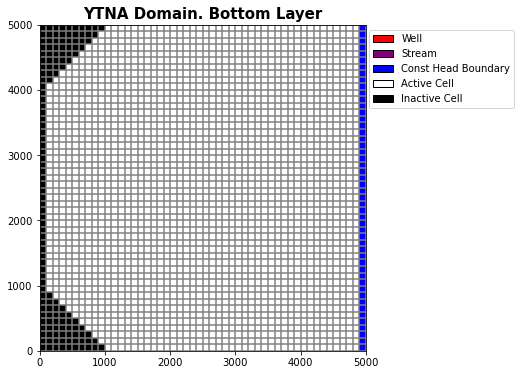

In [1061]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m2, layer=2) #everytime we need to plot something, we need to specify the model object.
ibound = mapview.plot_ibound()
wel = mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()
plt.legend(handles=[mp.patches.Patch(color='red',label='Well',ec='black'),
                    mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.47,1.0))
str_m = mapview.plot_bc("STR")
plt.title('YTNA Domain. Bottom Layer', fontsize = 15, fontweight = 'bold')

# 6. Read in the outputs

### 6.1 Modflow outputs - Heads and budget files
#### (Reading different model objects in the same script)

In [1062]:
#Head - 3 layer model 
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                 #returns a list of timesteps
head = headobj.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance - 3 layer
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
print(budgobj.get_unique_record_names())
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps                         #ISNT THIS SUPOSE TO BE BUDOBJ3??
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge = budgobj.get_data(text='RECHARGE', totim=1.0) 
print(len(frf))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
1


# 7. Plotting
### 7.1 Cross section plots

In [1063]:
#### YTNA model 
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)

# xsect = flopy.plot.PlotCrossSection(model=m2, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
# patches = xsect.plot_ibound(head=head)
# patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('YTNA Model - Row 25 Cross-Section')
# cb = plt.colorbar(pc, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)


### Read the Water balance and get the heads, ET and Recharge

In [1064]:
#### YTNA model 
budgobj = bf.CellBudgetFile(modelname+'.cbc')  # reads the cell budget file
kstpkper_list = budgobj.get_kstpkper() #returns a list of stress periods & timesteps
#dummy = budgobj.list_records()

#Get the ET from the cell budget files
et = budgobj.get_data(text='et', totim=1.0)
et_vals = np.squeeze(et)[0,:,:] #This is a matrix of the ET fluxes [m3/day] #NOTE I changed here from 1 to zero. Is it the layer number?
et_tot= np.sum(et_vals)
print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
recharge = budgobj.get_data(text='recharge', totim=1.0)
recharge_vals = np.squeeze(recharge)[1,:,:] #This is a matrix of the recharge fluxes [m3/day]
rch_tot = np.sum(recharge_vals)
print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain

# Get the flow rates on the cell right and front faces
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)
flux_vals = np.squeeze(frf)
leftflux = np.round(flux_vals[:, 0], 4)
rightflux = np.round(flux_vals[:, -2], 4)

# Calculate the total flux across the right and left side of the domain
right_tot = np.sum(rightflux)  # Note the units of this are L3/T
left_tot = np.sum(leftflux)

print('Left Flux =', left_tot, " Right_flux=", right_tot)


Total ET [m3/day]: 2500.0
Total Recharge [m3/day]: 0.0
Left Flux = 20.8591  Right_flux= 21.3427


### 7.2 Plot ET, Recharge and WTD

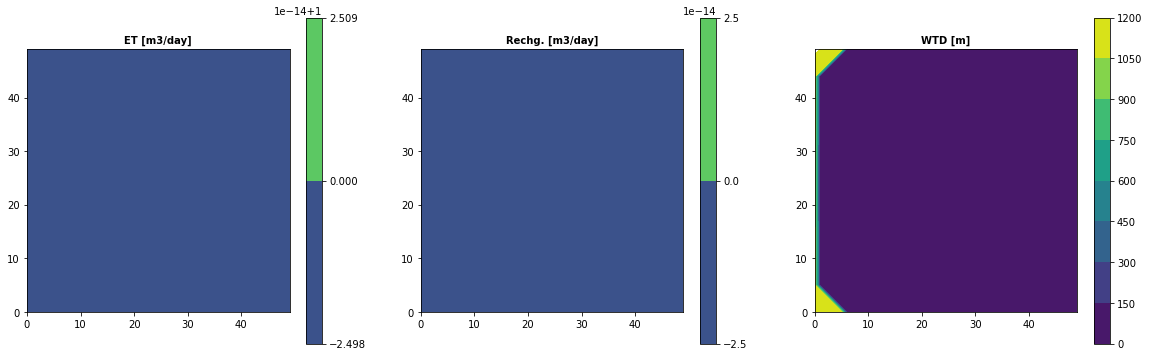

In [1065]:
#### YTNA model 
#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#fig.tight_layout(pad=1)
fig.set_figheight(10)
fig.set_figwidth(20)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
ax1.set_aspect('equal')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.6)

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
ax2.set_aspect('equal')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.6)

#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.6)

plt.show()


### 7.3 Plot head transect

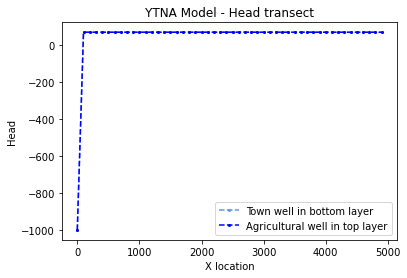

In [1066]:
#### YTNA model 
#Plotting the heads in the rows that contains the wells
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
plt.plot(x,head[2,int(well_row_town),:],marker='.', color='cornflowerblue', markersize=4, linestyle='--', label="Town well in bottom layer")
plt.plot(x,head[0,int(well_row_agric),:],marker='.', color='blue', markersize=4, linestyle='--', label="Agricultural well in top layer")
plt.title('YTNA Model - Head transect')
#plt.title('Head transect for layers with same properties')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()

plt.savefig('YTNA Model - Head_Transect.png')
#plt.savefig('Head_Transect for layers with same properties.png')

### 7.4 Layer head contours

C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


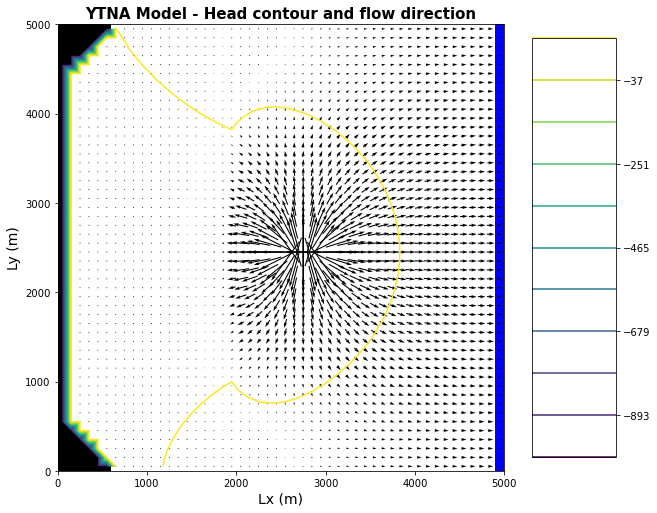

In [1067]:
#### YTNA model 
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m2, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0][0].min(),head[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('YTNA Model - Head contour and flow direction', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

#### 7.5 3D plot of heads

C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_27160\1372186194.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig_3d.gca(projection='3d')


Text(0.5, 0.92, 'YTNA Model - Steady-State Model Head Profile')

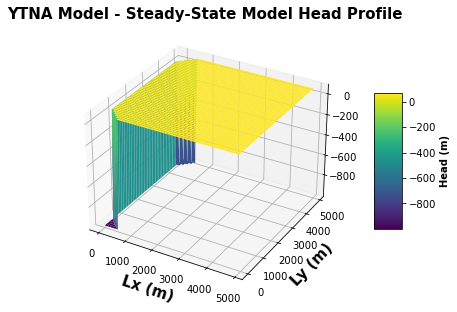

In [1068]:
#### YTNA model 
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('YTNA Model - Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

## Yes Town Yes Agric (YTYA)

## 3. Setup and run MODFLOW for the three layer scenario 

In [1069]:
#### YTYA model 
#Initialize the model
modelname = "YTYA"
m3 = flopy.modflow.Modflow(modelname, exe_name = moddir) #creating a new object to apply the packages to it

## Make some changes to the parameters
nlay=  3  #three layers instead of 1
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[0,:,:] = 45                 # bottom elevation of top layer (1) is 25 m RELATIVE to the bottom of the domain
botm[1,:,:] = 40                  # bottom elevation of middle layer (0) is 35 m RELATIVE to the bottom of the domain

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol). Now our K are 3D
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:] = 0.0001                   # Replace the K in the MIDDLE layer with the lower value

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#ibound[:, 0, :] = 0                                 #replace top border row (all zs, all ys, first x) with 0 to indicate no flow
#ibound[:, -1, :] = 0                                 #replace bottom border row (all zs, all ys, first x) with 0 to indicate no flow
ibound[:,:,0] = 0          #replace leftmost column (all zs, all ys, first x) with 0 to indicate no flow
ibound[:,:,-1] = -1          #replace rightmost column (all zs, all ys, first x) with <0 to indicate constant head
#Wall of rock on the left boundary. For-loop provided by Diana Hsieh.
for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+i] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
#rech_zone[: , 0:15] = recharge            #adding recharge to the most left 20 columns
rech_zone[21:23,19:21] = pistachios_rch
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)     #create rch object
rech_zone_df = pd.DataFrame(rech_zone)
rech_zone_df.to_csv()

#Well - Town
well_town = [i for i in well_loc_town] + [pumping_town]
print("Town Well [layer, row, column, flux]: \n", well_town)
#Well - Agric
well_agric = [i for i in well_loc_agric] + [pumping_agric]
print("Agric Well [layer, row, column, flux]: \n", well_agric)
#Fluxes
sp_fluxes = {0: [well_agric], 2: [well_town]} #putting the Town well in the bottom layer and the Agric well in the top layer
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=sp_fluxes, extension='wel')
print(sp_fluxes)

#ET
ET_zone = np.zeros((1,nrow,ncol)) #NOTE check it I need to add the nlay here or just leave like that    # define an array of zeros the size of the model grid
rightET = 1e-5
riparianET = 5e-4
ET_zone[:,:,26:-1] = rightET
ET_zone[:,22:29,:] = riparianET
extinction_depth = 1 #depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation
evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)



Town Well [layer, row, column, flux]: 
 [2, 21, 38, -1500]
Agric Well [layer, row, column, flux]: 
 [0, 12, 14, -375.0]
{0: [[0, 12, 14, -375.0]], 2: [[2, 21, 38, -1500]]}


## 4. STR Package - Model YTYA

In [1070]:
#### YTYA model 
#1. Setup the stream characteristics 
nseg = 3 # number of segments
ntrib = 2 # two tributaries (for return flow & upstream section)
slope = 0.001  #slope of streambed (m/m)
rough = 0.04 #roughness of streambed
width = 1. #x-sectional width of channel (m)
stage = 0.5 #head of the river
Flow_into_the_1st_reach = 0 # m^3/day
set_icalc = 1  # the stage is to be calculated based on flow
const = 86400.0 #multiplication constant for m3/day 
#2. Calculate the streambed conductance 
k_strbott = 10  #river bottom hydraulic conductivity in l/t
sed_thick = 1 #thickness of riverbed sediment 
cond = k_strbott*(width)*(dy)/(sed_thick) 

#3. Setup the reach locations stream segment numbers and reach numbers
#(Note we are taking a slightly more complicated approach here setting the streambed relative to the elevation of the land surface)
#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 24    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#Setup the inflows for the reaches
Qreturn = 50     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

#4. Setup the elevation of the streams
#(In this case we will be setting it relative to surface elevation which is an array called ‘ztop’)

ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage      # elevation of the water surface in the stream (m)

#5. Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#5. Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

#6. Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


## Run Flopy model with all the packages

In [1071]:
#### YTYA model 
#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: YTYA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21  6:27:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21  6:27:55
 Elapsed run time:  0.146 Seconds

  Normal termination of simulation


# 5. Plain view of the domain

Text(0.5, 1.0, 'YTYA Domain. Top Layer')

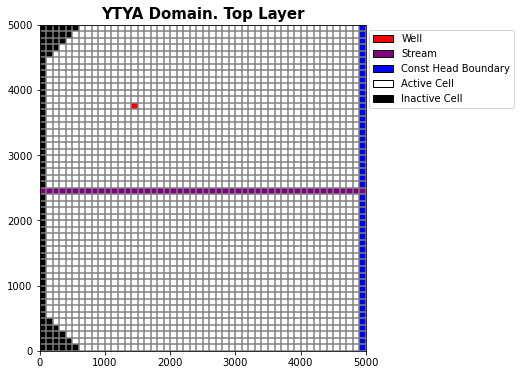

In [1072]:
#### YTYA model 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m3, layer=0) #everytime we need to plot something, we need to specify the model object.
ibound = mapview.plot_ibound()
well = mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()
plt.legend(handles=[mp.patches.Patch(color='red',label='Well',ec='black'),
                    mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.47,1.0))
str_m = mapview.plot_bc("STR")
plt.title('YTYA Domain. Top Layer', fontsize = 15, fontweight = 'bold')

# 6. Read in the outputs

### 6.1 Modflow outputs - Heads and budget files
#### (Reading different model objects in the same script)

In [1073]:
#Head - YTYA model 
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                 #returns a list of timesteps
head = headobj.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Water balance - 3 layer
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
print(budgobj.get_unique_record_names())
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps                         #ISNT THIS SUPOSE TO BE BUDOBJ3??
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge = budgobj.get_data(text='RECHARGE', totim=1.0) 
print(len(frf))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
1


# 7. Plotting
### 7.1 Cross section plots

In [1074]:
#### YTYA model 
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)

# xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
# patches = xsect.plot_ibound(head=head)
# patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')

# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('YTYA Model - Row 25 Cross-Section')
# cb = plt.colorbar(pc, shrink=0.75)
# patches = xsect.plot_bc('WEL', color='red')
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)


### Read the Water balance and get the heads, ET and Recharge

In [1075]:
#### YTYA model 
budgobj = bf.CellBudgetFile(modelname+'.cbc')  # reads the cell budget file
kstpkper_list = budgobj.get_kstpkper() #returns a list of stress periods & timesteps
#dummy = budgobj.list_records()

#Get the ET from the cell budget files
et = budgobj.get_data(text='et', totim=1.0)
et_vals = np.squeeze(et)[0,:,:] #This is a matrix of the ET fluxes [m3/day] #NOTE I changed here from 1 to zero. Is it the layer number?
et_tot= np.sum(et_vals)
print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
recharge = budgobj.get_data(text='recharge', totim=1.0)
recharge_vals = np.squeeze(recharge)[1,:,:] #This is a matrix of the recharge fluxes [m3/day]
rch_tot = np.sum(recharge_vals)
print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain

# Get the flow rates on the cell right and front faces
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)
flux_vals = np.squeeze(frf)
leftflux = np.round(flux_vals[:, 0], 4)
rightflux = np.round(flux_vals[:, -2], 4)

# Calculate the total flux across the right and left side of the domain
right_tot = np.sum(rightflux)  # Note the units of this are L3/T
left_tot = np.sum(leftflux)

print('Left Flux =', left_tot, " Right_flux=", right_tot)


Total ET [m3/day]: 2500.0
Total Recharge [m3/day]: 48.0
Left Flux = -273.1149  Right_flux= -139.8166


### 7.2 Plot ET, Recharge and WTD

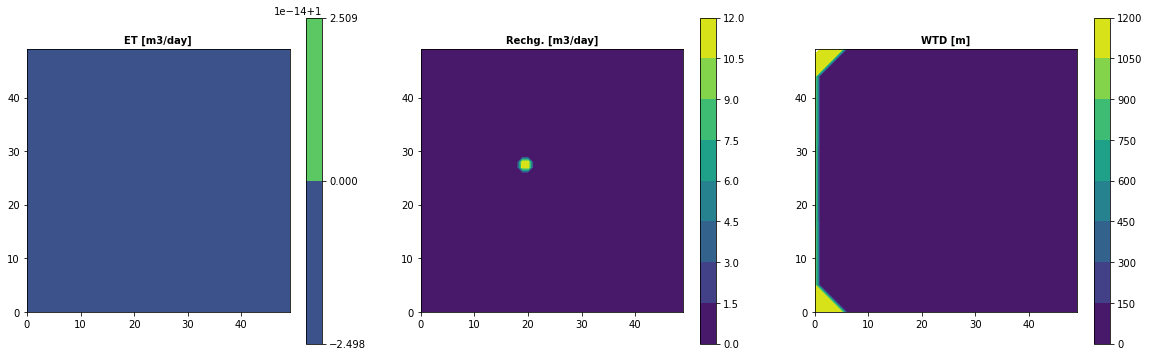

In [1076]:
#### YTYA model 
#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#fig.tight_layout(pad=1)
fig.set_figheight(10)
fig.set_figwidth(20)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
ax1.set_aspect('equal')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.6)

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
ax2.set_aspect('equal')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.6)

#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head
#ax3.set_xlabel('Lx (m)', fontsize=10)
#ax3.set_ylabel('Ly (m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
ax3.set_aspect('equal')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.6)

plt.show()


### 7.3 Plot head transect

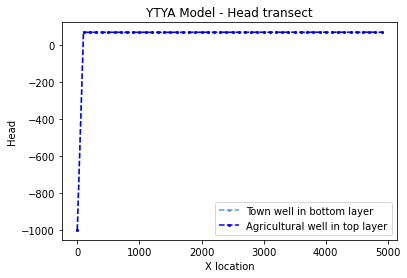

In [1077]:
#### YTYA model 
#Plotting the heads in the rows that contains the wells
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
plt.plot(x,head[2,int(well_row_town),:],marker='.', color='cornflowerblue', markersize=4, linestyle='--', label="Town well in bottom layer")
plt.plot(x,head[0,int(well_row_agric),:],marker='.', color='blue', markersize=4, linestyle='--', label="Agricultural well in top layer")
plt.title('YTYA Model - Head transect')
#plt.title('Head transect for layers with same properties')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()

plt.savefig('YTYA Model - Head_Transect.png')
#plt.savefig('Head_Transect for layers with same properties.png')

### 7.4 Layer head contours

C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


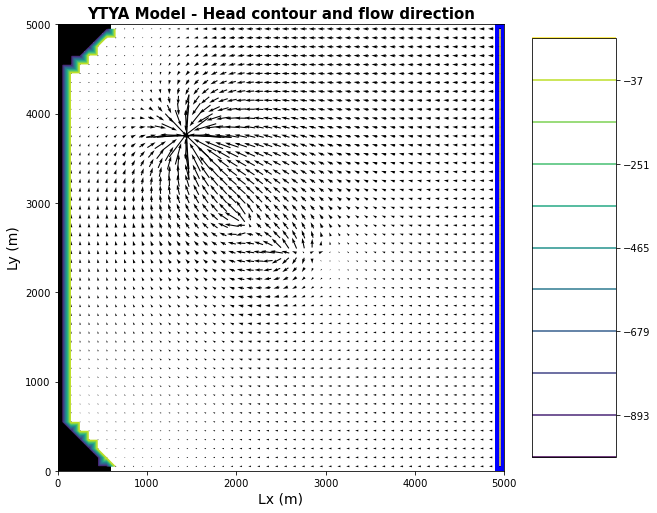

In [1078]:
#### YTYA model 
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0][0].min(),head[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('YTYA Model - Head contour and flow direction', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

#### 7.5 3D plot of heads

C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_27160\1234125442.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig_3d.gca(projection='3d')


Text(0.5, 0.92, 'YTYA Model - Steady-State Model Head Profile')

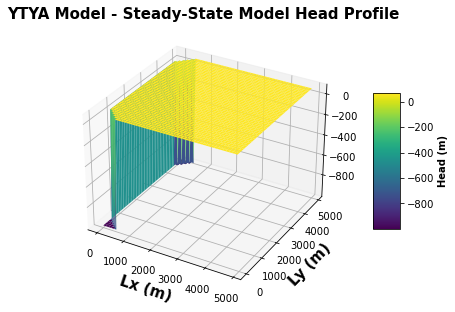

In [1079]:
#### YTYA model 
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('YTYA Model - Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

In [1080]:
#### Plot in progress 
# Reading budget and head output files
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

#str_outflow = budgobj.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

#Preparing variables for plotting 
#leakage = leak[0]
#str_outflow = str_outflow[0]
str_inflow = str_outflow[:nrow-1]
str_inflow = str_inflow['q']
str_inflow = str_inflow.tolist()
str_inflow.insert(0, Flow_into_the_1st_reach) 
reach = np.arange(0,nrow,1) + 1
head_reach=[]
x_str = strspd[0][2]
x_str=int(x_str)
for i in range(nrow):
    head_reach.append(head[0][i][x_str])

#####################################################################
# Plotting reach wise water budget
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#ax.set_aspect('equal')
ax1.set_title('Flows')
# ax1.plot(reach, leakage['q'], lw=3, label="Leaked to Aquifer", marker='o') 
ax1.plot(reach, str_outflow['q'], label="Flow out", marker='.') 
ax1.plot(reach, str_inflow, color='red', label="Flow in", linestyle='--', marker='.') 
# ax1.axhline(y=0,  color='black', linestyle='--')
ax1.set_xlabel('Row Number')
#ax1.set_xticks(reach)
ax1.set_ylabel('Flow (m^3/d)')
ax1.legend()

# Plotting reach wise heads
ax2.set_title('Heads')
ax2.axhline(y=str_stage,  color='blue', label="Stage Head")
ax2.plot(reach, head_reach, color='red', label="Head in the Cell", marker='.') 
ax2.axhline(y=str_top,  color='yellow', linestyle='--', label="Streambed Top")
ax2.axhline(y=str_bott,  color='brown', linestyle='--', label="Streambed Bottom")
ax2.set_xlabel('Row Number')
#ax2.set_xticks(reach)
ax2.set_ylabel('Head (m)')
ax2.legend()

NameError: name 'str_outflow' is not defined